# Goal Conditioned Value function

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import imageio
from IPython.display import Video, display
import json
import os

from src.isometry import Isometry
from src.jepa import JEPA
from src.data.dataset import PointMazeSequences
from envs.pointmaze import PointMazeEnv


os.environ["MUJOCO_GL"] = "egl"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Preamble

### Model

We begin by loading the checkpoint of the trained model



In [2]:
# model = Isometry.load_from_checkpoint(
#     "checkpoints/isometry/last-v10.ckpt"
# )
model = JEPA.load_from_checkpoint(
    "checkpoints/jepa/last-v18.ckpt"
)
model.eval();

### Environment

We then proceed by loading the possible layouts and creating a PointMaze environment

In [3]:
with open('data/train_layouts.json', "r") as f:
    maze_maps = json.load(f)["maps"]

map_idx = 1
maze_map = maze_maps[map_idx]

In [4]:
side = max(len(maze_map), len(maze_map[0])) + 2
env = PointMazeEnv(
    maze_map=maze_map,
    render_goal=False,
    render_img_size=(64, 64),
    camera_distance=side
)
env.reset();

Choose initial and goal position

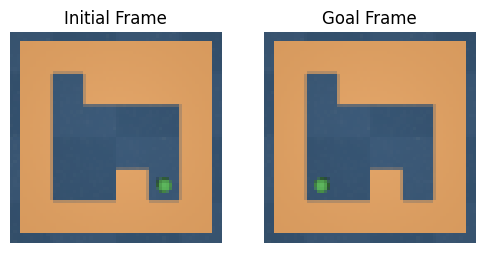

In [5]:
# goal_position = np.array([-1.5, -0.5])
goal_position = np.array([1.5, 1.5])
goal_state = np.array([goal_position[0], goal_position[1], 0.0, 0.0])
env.set_position(goal_position);
goal_frame = env.render()

# initial_position = np.array([-0.5, -1.5])
initial_position = np.array([1.5, -1.5])
initial_state = np.array([initial_position[0], initial_position[1], 0.0, 0.0])
env.set_position(initial_position);    
initial_frame = env.render()

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(initial_frame)
axs[0].set_title("Initial Frame")
axs[0].axis('off')
axs[1].imshow(goal_frame)
axs[1].set_title("Goal Frame")
axs[1].axis('off')
plt.show()

## Reconstruction

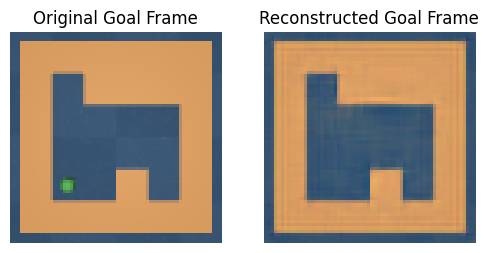

In [6]:
with torch.no_grad():
    initial_state = torch.tensor(initial_state, device=device).unsqueeze(0).float()
    goal_state = torch.tensor(goal_state, device=device).unsqueeze(0).float()

    z_goal_frame = model.visual_encoder(
        torch.from_numpy(goal_frame.copy()).permute(2, 0, 1).unsqueeze(0).float().to(device) / 255.0
    ).squeeze(0).cpu().numpy()
    recon_goal_frame = model.visual_decoder(
        torch.from_numpy(z_goal_frame).unsqueeze(0).float().to(device)
    ).squeeze(0).permute(1, 2, 0).cpu().numpy() * 255.0

fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(goal_frame)
axs[0].set_title("Original Goal Frame")
axs[0].axis('off')
axs[1].imshow(recon_goal_frame.astype(np.uint8))
axs[1].set_title("Reconstructed Goal Frame")
axs[1].axis('off')
plt.show()

## Value Function

Sample inside the walkable part

In [7]:
def rotate90_and_hflip(coords):
    return np.column_stack([-coords[:, 1], -coords[:, 0]])

In [8]:
centers = np.array(env.maze.unique_reset_locations)
samples = []
for center in centers:
    # Create grid
    x_min, x_max = center[0] - 0.48, center[0] + 0.48
    y_min, y_max = center[1] - 0.48, center[1] + 0.48
    # x_min, x_max = center[0] - 1.48, center[0] + 1.48
    # y_min, y_max = center[1] - 1.48, center[1] + 1.48
    resolution = 30
    x = np.linspace(x_min, x_max, resolution)
    y = np.linspace(y_min, y_max, resolution)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.column_stack([xx.ravel(), yy.ravel()])
    samples.append(grid_points)
samples = np.vstack(samples)

centers_rotated = rotate90_and_hflip(centers)
samples_rotated = rotate90_and_hflip(samples)

Render positions

In [9]:
frames = []
for point in samples:
    env.set_position(point)
    frame = env.render()
    frames.append(frame)
frames = np.array(frames)

Visualize coverage

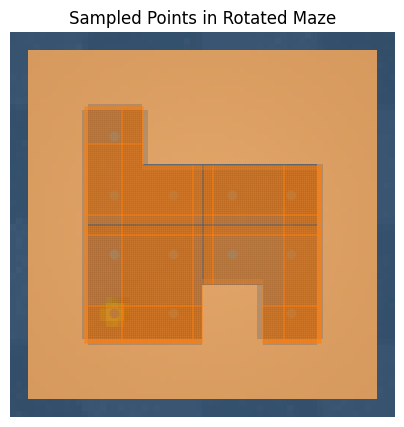

In [10]:
plt.figure(figsize=(5, 5))
plt.imshow(goal_frame, extent=(-3.25, 3.25, -3.25, 3.25))
plt.scatter(centers_rotated[:, 0], centers_rotated[:, 1])
plt.scatter(samples_rotated[:, 0], samples_rotated[:, 1], s=1, alpha=0.5)
plt.title("Sampled Points in Rotated Maze")
x_lim = ( -3.25, 3.25 )
y_lim = ( -3.25, 3.25 )
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()

Prepare data

In [11]:
frames_th = torch.from_numpy(frames.copy()).permute(0, 3, 1, 2) / 255.0
goal_frame_th = torch.from_numpy(goal_frame.copy()).permute(2, 0, 1).unsqueeze(0) / 255.0

frames_dataset = torch.utils.data.TensorDataset(frames_th)
frames_loader = torch.utils.data.DataLoader(
    frames_dataset, batch_size=1024, shuffle=False
)

Compute value function

In [12]:
with torch.no_grad():
    z_goal_frame_1 = model.visual_encoder(goal_frame_th.to(device))
    _zeros = torch.zeros_like(z_goal_frame_1[:, :2, :, :], device=device, dtype=z_goal_frame_1.dtype)
    _z_goal_frame_1 = torch.cat([z_goal_frame_1, _zeros], dim=1)
    # z_goal_frame_2 = model.isometry_head_cnn(_z_goal_frame_1)
    # z_goal_frame_3 = model.isometry_head_mlp(z_goal_frame_2)
    
    z_goal_frame_1 = z_goal_frame_1.cpu()
    # z_goal_frame_2 = z_goal_frame_2.cpu()
    # z_goal_frame_3 = z_goal_frame_3.cpu()

In [13]:
distances_1_l2, distances_1_cos = [], []
distances_2_l2, distances_2_cos = [], []
distances_3_l2, distances_3_cos = [], []
with torch.no_grad():
    for batch in frames_loader:
        batch = batch[0].to(device)
        z_batch_1 = model.visual_encoder(batch)
        # Concat velocity zero
        _zeros = torch.zeros_like(z_batch_1[:, :2, :, :], device=device, dtype=z_batch_1.dtype)
        _z_batch_1 = torch.cat([z_batch_1, _zeros], dim=1)
        # z_batch_2 = model.isometry_head_cnn(_z_batch_1)
        # z_batch_3 = model.isometry_head_mlp(z_batch_2)
        
        # Compute cosine similarity distance
        # z_batch = z_batch.flatten(1, 3)
        
        # Cosine after visual encoder
        dists_1_cos = 1 - F.cosine_similarity(z_batch_1.cpu().flatten(1, 3), z_goal_frame_1.flatten(1, 3))
        distances_1_cos.append(dists_1_cos.numpy())
        # Cosine after isometry CNN
        # dists_2_cos = 1 - F.cosine_similarity(z_batch_2.cpu().flatten(1, 3), z_goal_frame_2.flatten(1, 3))
        # distances_2_cos.append(dists_2_cos.numpy())
        # Cosine after isometry MLP
        # dists_3_cos = 1 - F.cosine_similarity(z_batch_3.cpu(), z_goal_frame_3)
        # distances_3_cos.append(dists_3_cos.numpy())

        # # L2 after visual encoder
        dist_1_l2 = torch.mean((z_batch_1.cpu().flatten(1, 3) - z_goal_frame_1.flatten(1, 3))**2, dim=1)
        distances_1_l2.append(dist_1_l2.numpy())
        # # L2 after isometry CNN
        # dist_2_l2 = torch.mean((z_batch_2.cpu().flatten(1, 3) - z_goal_frame_2.flatten(1, 3))**2, dim=1)
        # distances_2_l2.append(dist_2_l2.numpy())
        # # L2 after isometry MLP
        # dist_3_l2 = torch.mean((z_batch_3.cpu() - z_goal_frame_3)**2, dim=1)
        # distances_3_l2.append(dist_3_l2.numpy())


distances_1_cos = np.concatenate(distances_1_cos)
# distances_2_cos = np.concatenate(distances_2_cos)
# distances_3_cos = np.concatenate(distances_3_cos)
distances_1_l2 = np.concatenate(distances_1_l2)
# distances_2_l2 = np.concatenate(distances_2_l2)
# distances_3_l2 = np.concatenate(distances_3_l2)

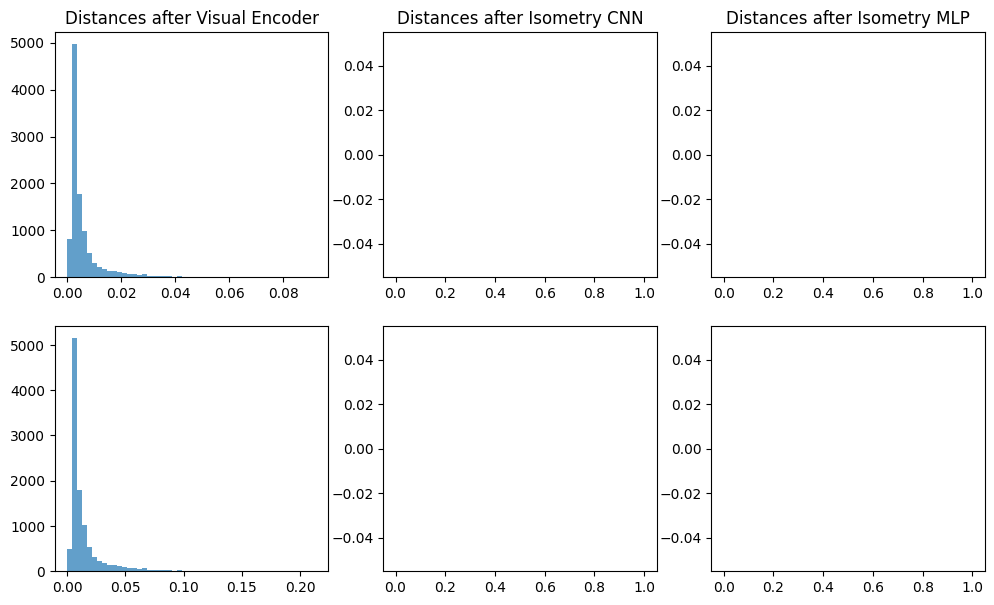

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(12, 7))
axs[0, 0].hist(distances_1_cos, bins=50, alpha=0.7)
axs[0, 0].set_title("Distances after Visual Encoder")
axs[0, 1].hist(distances_2_cos, bins=50, alpha=0.7)
axs[0, 1].set_title("Distances after Isometry CNN")
axs[0, 2].hist(distances_3_cos, bins=50, alpha=0.7)
axs[0, 2].set_title("Distances after Isometry MLP")
axs[1, 0].hist(distances_1_l2, bins=50, alpha=0.7)
# axs[1, 0].set_title("L2 Distances after Visual Encoder")
axs[1, 1].hist(distances_2_l2, bins=50, alpha=0.7)
# axs[1, 1].set_title("L2 Distances after Isometry CNN")
axs[1, 2].hist(distances_3_l2, bins=50, alpha=0.7)
# axs[1, 2].set_title("L2 Distances after Isometry MLP")
plt.show()

In [15]:
def pit_empirical(x):
    """Probability Integral Transform using empirical CDF."""
    x = np.asarray(x)
    ranks = np.argsort(np.argsort(x)) + 1   # 1..N
    u = ranks / (len(x) + 1)                # avoid 0 and 1
    return u

def minmax_normalize(x):
    x_min = np.min(x)
    x_max = np.max(x)
    return (x - x_min) / (x_max - x_min)

In [16]:
def plot_heatmap(
    samples_rotated,
    distances_1_cos,
    distances_2_cos,
    distances_3_cos,
    distances_1_l2,
    distances_2_l2,
    distances_3_l2,
    x_lim, y_lim,
    pit=False,
    prepit = False,
    prenorm = False
):
    if prenorm:
        distances_1_cos = (distances_1_cos - distances_1_cos.min()) / (distances_1_cos.max() - distances_1_cos.min())
        distances_2_cos = (distances_2_cos - distances_2_cos.min()) / (distances_2_cos.max() - distances_2_cos.min())
        distances_3_cos = (distances_3_cos - distances_3_cos.min()) / (distances_3_cos.max() - distances_3_cos.min())
        distances_1_l2 = (distances_1_l2 - distances_1_l2.min()) / (distances_1_l2.max() - distances_1_l2.min())
        distances_2_l2 = (distances_2_l2 - distances_2_l2.min()) / (distances_2_l2.max() - distances_2_l2.min())
        distances_3_l2 = (distances_3_l2 - distances_3_l2.min()) / (distances_3_l2.max() - distances_3_l2.min())

    if prepit:
        distances_1_cos = pit_empirical(distances_1_cos)
        distances_2_cos = pit_empirical(distances_2_cos)
        distances_3_cos = pit_empirical(distances_3_cos)
        distances_1_l2 = pit_empirical(distances_1_l2)
        distances_2_l2 = pit_empirical(distances_2_l2)
        distances_3_l2 = pit_empirical(distances_3_l2)


    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    _distances_1_cos = distances_1_cos if not pit else pit_empirical(distances_1_cos)
    _distances_2_cos = distances_2_cos if not pit else pit_empirical(distances_2_cos)
    _distances_3_cos = distances_3_cos if not pit else pit_empirical(distances_3_cos)
    im1 = axs[0, 0].scatter(samples_rotated[:, 0], samples_rotated[:, 1], c=_distances_1_cos, cmap='viridis', s=5)
    axs[0, 0].set_title("Cosine Distance after Visual Encoder")
    axs[0, 0].set_xlim(x_lim)
    axs[0, 0].set_ylim(y_lim)
    axs[0, 0].set_aspect('equal', adjustable='box')
    axs[0, 0].axis('off')
    # fig.colorbar(im1, ax=axs[0, 0], fraction=0.046, pad=0.04)
    im2 = axs[0, 1].scatter(samples_rotated[:, 0], samples_rotated[:, 1], c=_distances_2_cos, cmap='viridis', s=5)  
    axs[0, 1].set_title("Cosine Distance after Isometry CNN")
    axs[0, 1].set_xlim(x_lim)
    axs[0, 1].set_ylim(y_lim)
    axs[0, 1].set_aspect('equal', adjustable='box')
    axs[0, 1].axis('off')
    # fig.colorbar(im2, ax=axs[0, 1], fraction=0.046, pad=0.04)
    im3 = axs[0, 2].scatter(samples_rotated[:, 0], samples_rotated[:, 1], c=_distances_3_cos, cmap='viridis', s=5)  
    axs[0, 2].set_title("Cosine Distance after Isometry MLP")
    axs[0, 2].set_xlim(x_lim)
    axs[0, 2].set_ylim(y_lim)
    axs[0, 2].set_aspect('equal', adjustable='box')
    axs[0, 2].axis('off')
    # fig.colorbar(im3, ax=axs[0, 2], fraction=0.046, pad=0.04)
    _distances_1_l2 = distances_1_l2 if not pit else pit_empirical(distances_1_l2)
    _distances_2_l2 = distances_2_l2 if not pit else pit_empirical(distances_2_l2)
    _distances_3_l2 = distances_3_l2 if not pit else pit_empirical(distances_3_l2)
    im4 = axs[1, 0].scatter(samples_rotated[:, 0], samples_rotated[:, 1], c=_distances_1_l2, cmap='viridis', s=5)
    axs[1, 0].set_title("L2 Distance after Visual Encoder")
    axs[1, 0].set_xlim(x_lim)
    axs[1, 0].set_ylim(y_lim)
    axs[1, 0].set_aspect('equal', adjustable='box')
    axs[1, 0].axis('off')
    # fig.colorbar(im4, ax=axs[1, 0], fraction=0.046, pad=0.04)
    im5 = axs[1, 1].scatter(samples_rotated[:, 0], samples_rotated[:, 1], c=_distances_2_l2, cmap='viridis', s=5)  
    axs[1, 1].set_title("L2 Distance after Isometry CNN")
    axs[1, 1].set_xlim(x_lim)
    axs[1, 1].set_ylim(y_lim)
    axs[1, 1].set_aspect('equal', adjustable='box')
    axs[1, 1].axis('off')
    # fig.colorbar(im5, ax=axs[1, 1], fraction=0.046, pad=0.04)
    im6 = axs[1, 2].scatter(samples_rotated[:, 0], samples_rotated[:, 1], c=_distances_3_l2, cmap='viridis', s=5)  
    axs[1, 2].set_title("L2 Distance after Isometry MLP")
    axs[1, 2].set_xlim(x_lim)
    axs[1, 2].set_ylim(y_lim)
    axs[1, 2].set_aspect('equal', adjustable='box')
    axs[1, 2].axis('off')
    # fig.colorbar(im6, ax=axs[1, 2], fraction=0.046, pad=0.04)
    plt.show()

---

In [17]:
from scipy import stats
from tabulate import tabulate

candidates = {
    "exponential": stats.expon,
    "gamma": stats.gamma,
    "lognorm": stats.lognorm,
    "weibull": stats.weibull_min,
}

results = {}

x = np.log(distances_1_cos+1000)
for name, dist in candidates.items():
    params = dist.fit(x)
    loglik = np.sum(dist.logpdf(x, *params))
    results[name] = {"params": params, "loglik": loglik}

# Sort by best log-likelihood
results = dict(sorted(results.items(), key=lambda t: t[1]["loglik"], reverse=True))
print(tabulate(
    [(name, round(res["loglik"])) for name, res in results.items()],
    headers=["Distribution", "AIC"],
    tablefmt="fancy_grid",
))

╒════════════════╤════════╕
│ Distribution   │    AIC │
╞════════════════╪════════╡
│ lognorm        │ 120211 │
├────────────────┼────────┤
│ exponential    │ 118258 │
├────────────────┼────────┤
│ weibull        │ 116477 │
├────────────────┼────────┤
│ gamma          │  84858 │
╘════════════════╧════════╛


In [18]:
best_name = list(results.keys())[0]
best_dist = candidates[best_name]
print("Best distribution:", best_name)
print(f"loglik: {results[best_name]['loglik']:e}")
best_params = results[best_name]["params"]

xx = np.linspace(x.min(), x.max(), 500)
pdf = best_dist.pdf(xx, *best_params)

# plt.figure(figsize=(6,3))
# plt.hist(x, bins=80, density=True, alpha=0.5, label="Data")
# plt.plot(xx, pdf, "r", label=f"Fitted {best_name}")
# plt.legend()
# plt.show()

Best distribution: lognorm
loglik: 1.202109e+05


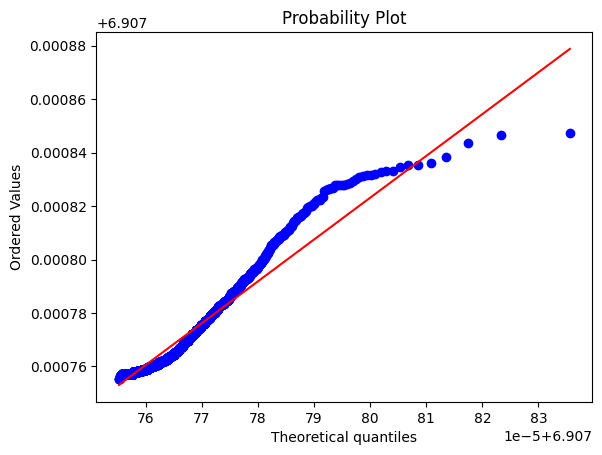

In [19]:
stats.probplot(x, dist=best_dist, sparams=best_params, plot=plt);

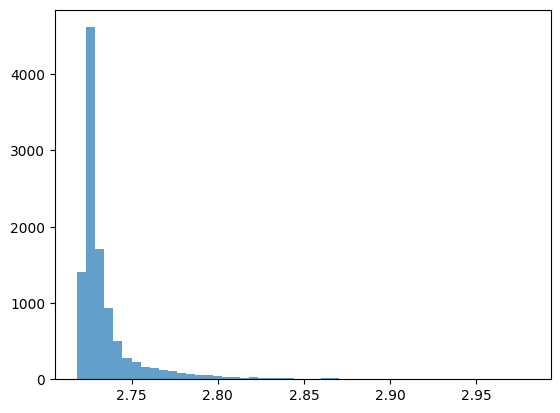

In [20]:
def transform(x):
    x = np.exp(1+x)
    return x

plt.hist(transform(distances_1_cos), bins=50, alpha=0.7);

---

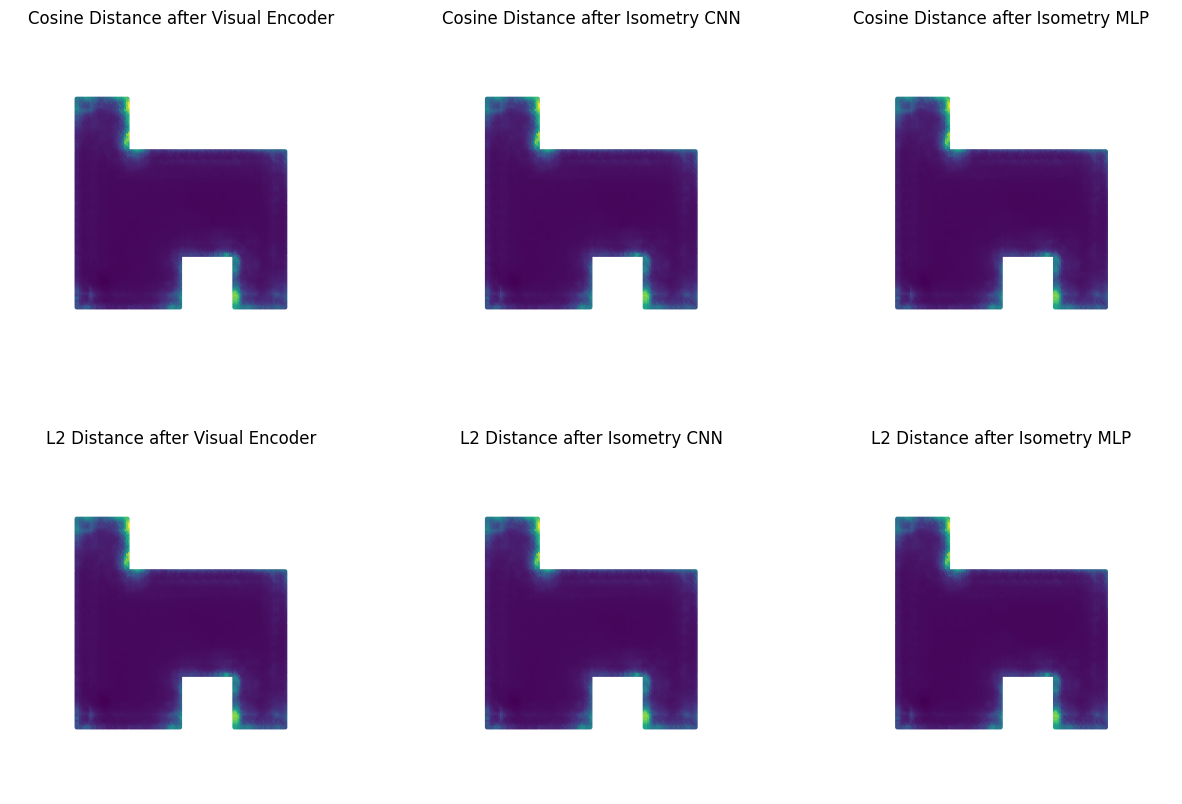

In [21]:
# plot_heatmap(
#     samples_rotated,
#     distances_1_cos, distances_2_cos, distances_3_cos,
#     distances_1_l2, distances_2_l2, distances_3_l2,
#     x_lim, y_lim,
#     pit=True
# )
plot_heatmap(
    samples_rotated,
    distances_1_cos, distances_1_cos, distances_1_cos,
    distances_1_l2, distances_1_l2, transform(distances_1_l2),
    x_lim, y_lim,
    pit=False, prepit = False, prenorm=False
)

Visualize 

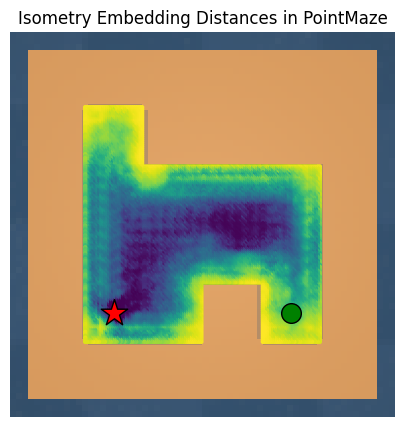

In [22]:
# Apply probability integral transform to distances
distances_pobs = pit_empirical(distances_1_l2)
# distances_pobs = transform(distances_1_cos)
# Pass the distances through exponential distribution CDF
# distances_pobs = candidates['exponential'].cdf(distances_1_cos)

plt.figure(figsize=(5, 5))
plt.imshow(goal_frame, extent=(-3.25, 3.25, -3.25, 3.25))
sc = plt.scatter(
    samples_rotated[:, 0], samples_rotated[:, 1],
    c=distances_pobs, cmap='viridis', s=5
)
# plt.colorbar(sc, label='Cosine Distance to Goal Frame')

# Initial position marker
initial_pos_rotated = rotate90_and_hflip(initial_position.reshape(1, -1))
plt.scatter(
    initial_pos_rotated[0, 0], initial_pos_rotated[0, 1],
    color='green', s=200, edgecolor='black', label='Initial Position'
)
# Goal position marker
goal_pos_rotated = rotate90_and_hflip(goal_position.reshape(1, -1))
plt.scatter(
    goal_pos_rotated[0, 0], goal_pos_rotated[0, 1],
    color='red', s=400, edgecolor='black', label='Goal Position', marker='*'
)

plt.title("Isometry Embedding Distances in PointMaze")
plt.xlim(-3.25, 3.25)
plt.ylim(-3.25, 3.25)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()

## Planning

In [23]:
with torch.no_grad():
    _zeros = torch.zeros(1, 2, z_goal_frame.shape[1], z_goal_frame.shape[2], device=device, requires_grad=True)
    z_init = model.visual_encoder(
        torch.from_numpy(initial_frame.copy()).permute(2, 0, 1).unsqueeze(0).float().to(device) / 255.0
    )
    z_goal = model.visual_encoder(
        torch.from_numpy(goal_frame.copy()).permute(2, 0, 1).unsqueeze(0).float().to(device) / 255.0
    )
    z_init = torch.cat([z_init, _zeros], dim=1)
    z_goal = torch.cat([z_goal, _zeros], dim=1) 

    z_init = z_init.squeeze(0)
    z_goal = z_goal.squeeze(0)

In [24]:
channel_mask = torch.ones(18, dtype=torch.long)
channel_mask[-2:] = 0  # Only consider position channels
print(channel_mask)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0])


In [25]:
from planning import GradientPlanner
from planning.base_planner import CostConfig
from planning.utils import create_channel_mask


cost_config = CostConfig(
    goal_weight=1.0,
    trajectory_weight=0.1,
    smoothness_weight=1e-2,
)
channel_mask = create_channel_mask(18, 'visual_only')

In [26]:
planner = GradientPlanner(
    model,
    action_dim=2,
    action_bounds=(-1,1),
    initial_lr=1e-1,
    final_lr=1e-2,
    num_iterations=100,
    cost_config=cost_config,
    channel_mask=channel_mask,
    noise_std=0.8,
    noise_decay=0.95,
    grad_clip=1.0,
)
result = planner.optimize(
    z_init,
    z_goal,
    horizon=150,
    verbose=True
)
best_actions = result['actions'].cpu().numpy()
cost_history = result['cost_history']

Gradient Opt:   0%|          | 0/100 [00:00<?, ?it/s]

Gradient Opt: 100%|██████████| 100/100 [00:09<00:00, 10.11it/s, cost=1815.9529, best=1815.4124, grad=0.8751, noise=0.0047]


In [27]:
# def smoothness_score(planner, z_init, z_goal, actions,
#                      eps=1e-3, num_samples=20):

#     x0 = actions.flatten()
#     base_cost = planner.rollout.total_cost(
#         planner.rollout.rollout(z_init, actions),
#         z_goal, actions, planner.cost_config
#     ).item()

#     scores = []
#     for _ in range(num_samples):
#         v = torch.randn_like(x0)
#         v = v / v.norm()
#         x = x0 + eps * v
#         act = x.view_as(actions)

#         traj = planner.rollout.rollout(z_init, act)
#         cost = planner.rollout.total_cost(traj, z_goal, act, planner.cost_config).item()

#         scores.append(abs(cost - base_cost) / eps)
    
#     return sum(scores) / len(scores)

# smoothness = smoothness_score(planner, z_init, z_goal, result['actions'])
# print("Smoothness:", smoothness)
# print("Normalized Smoothness:", (smoothness / result['cost_history'][0]))

In [28]:
# from planning import MPPIPlanner

# planner = MPPIPlanner(
#     jepa_model = model,
#     action_dim = 2,
#     action_bounds = (-1.0, 1.0),
#     channel_mask = channel_mask.to(device),
#     cost_config = cost_config,
#     # MPPI parameters
#     num_samples = 64,
#     num_iterations = 200,
#     temperature = 1.0,
#     noise_sigma = 0.5,
#     noise_decay = 0.98,
#     # Elite retention
#     # num_elites = 64,
#     elite_weight = 0.3,
#     adaptive_temp = True,
# )
# result = planner.optimize(
#     z_init,
#     z_goal,
#     horizon=150,
#     verbose=True
# )
# best_actions = result['actions'].cpu().numpy()
# cost_history = result['cost_history']

In [29]:
# from planning import CMAESPlanner


# planner = CMAESPlanner(
#     jepa_model=model,
#     action_dim=2,
#     action_bounds=(-1.0, 1.0),
#     channel_mask=channel_mask,
#     cost_config=cost_config,
#     # CMA-ES parameters
#     population_size=256,
#     num_generations=300,
#     sigma=1,
#     elite_fraction=0.25,
#     # Adaptive parameters
#     sigma_decay=0.995,
#     min_sigma=0.01,
#     retain_best=True,
#     covariance_type='full',
# )
# result = planner.optimize(
#     z_init,
#     z_goal,
#     horizon=150,
#     verbose=True
# )
# best_actions = result['actions'].cpu().numpy()
# cost_history = result['cost_history']

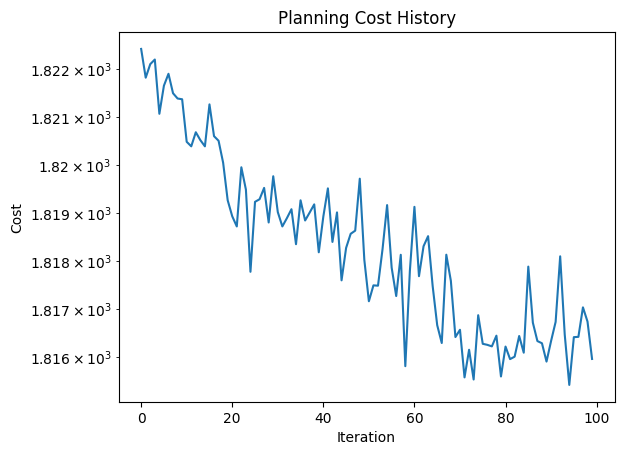

In [30]:
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Planning Cost History")
plt.yscale('log')

In [31]:
# Simulate the planned actions in the environment
env.reset()
env.set_position(initial_position)
frames = []
frames.append(env.render())
positions = [initial_position.copy()]
for action in best_actions:
    obs_dict, _, _, _, _ = env.step(action)
    frame = env.render()
    frames.append(frame)
    positions.append(obs_dict['observation'][:2])
frames = np.array(frames)
positions = np.array(positions)

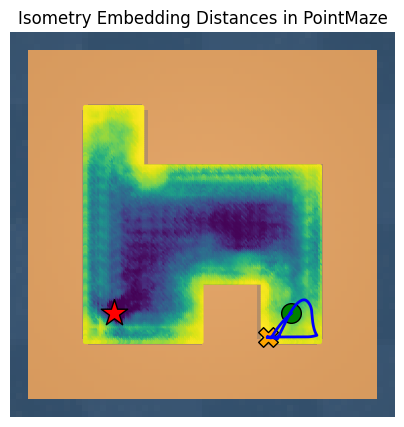

In [32]:
# Apply probability integral transform to distances
distances_pobs = pit_empirical(distances_1_l2)

plt.figure(figsize=(5, 5))
plt.imshow(goal_frame, extent=(-3.25, 3.25, -3.25, 3.25))
sc = plt.scatter(
    samples_rotated[:, 0], samples_rotated[:, 1],
    c=distances_pobs, cmap='viridis', s=5
)
# plt.colorbar(sc, label='Cosine Distance to Goal Frame')

# Initial position marker
initial_pos_rotated = rotate90_and_hflip(initial_position.reshape(1, -1))
plt.scatter(
    initial_pos_rotated[0, 0], initial_pos_rotated[0, 1],
    color='green', s=200, edgecolor='black', label='Initial Position'
)
# Goal position marker
goal_pos_rotated = rotate90_and_hflip(goal_position.reshape(1, -1))
plt.scatter(
    goal_pos_rotated[0, 0], goal_pos_rotated[0, 1],
    color='red', s=400, edgecolor='black', label='Goal Position', marker='*'
)

# Planned path
positions_rotated = rotate90_and_hflip(positions)
plt.plot(
    positions_rotated[:, 0], positions_rotated[:, 1],
    color='blue', linewidth=2, label='Planned Path'
)
plt.scatter(
    positions_rotated[-1, 0], positions_rotated[-1, 1],
    color='orange', s=200, edgecolor='black', label='Final Position', marker='X'
)

plt.title("Isometry Embedding Distances in PointMaze")
plt.xlim(-3.25, 3.25)
plt.ylim(-3.25, 3.25)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()

In [31]:
result['smoothness_cost'] / result['cost_history'][0]

0.002473269296666369

---

In [32]:
from tqdm import tqdm

In [186]:
z_last = z_init.clone()
state_last = initial_state.cpu().numpy().copy()[0]
goal_xy = goal_state[0, :2].cpu().numpy().copy()[0]

env.reset()
env.set_position(state_last[:2])

max_steps = 150
replan = 10
goal_threshold = 0.05
actions = []
states = [state_last.copy()[:2]]
frames = [env.render()]

for step in tqdm(range(max_steps // replan)):
    
    # --- PLAN ---
    result = planner.optimize(
        z_last,
        z_goal,
        horizon=100,
        verbose=False
    )
    planned_actions = result['actions'][:replan].cpu().numpy()
    actions.append(planned_actions)

    # --- EXECUTE IN REAL ENV ---
    for action in planned_actions:
        obs_dict, _, _, _, _ = env.step(action)
        state = obs_dict['observation']
        pos = state[:2]                    # (x, y) real coordinates
        frame = env.render()

        states.append(pos.copy())
        frames.append(frame)

        # update for next iteration
        state_last = state

        # -----------------------------------------------------
        # 🔥 REAL GOAL CHECK USING (x,y)
        # -----------------------------------------------------
        dist_xy = np.linalg.norm(pos - goal_xy)
        if dist_xy < goal_threshold:
            print(f"Goal reached at step {len(states)}  dist={dist_xy:.4f}")
            break
        # -----------------------------------------------------

    # Stop outer loop if goal reached
    if dist_xy < goal_threshold:
        break

    # --- RE-ENCODE LATENT FOR NEXT MPC REPLAN ---
    with torch.no_grad():
        st = torch.from_numpy(state_last[2:].copy()).unsqueeze(0).float().to(device)
        fr = torch.from_numpy(frame.copy()).permute(2,0,1).unsqueeze(0).float().to(device)
        z_last = model.encode_state(st, fr).squeeze(0)

positions = np.array(states)[:, :2]

100%|██████████| 15/15 [01:36<00:00,  6.46s/it]


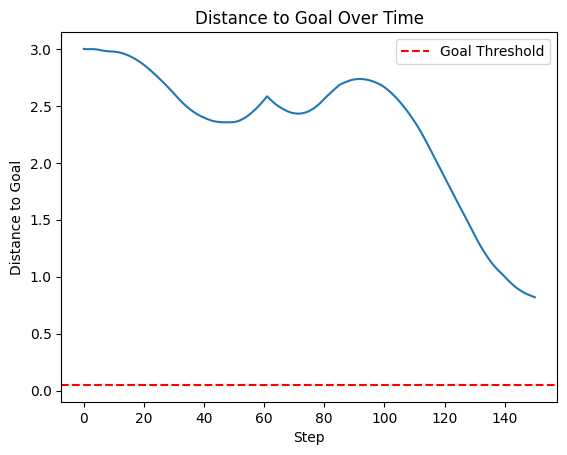

In [187]:
plt.plot(((positions-goal_position)**2).sum(axis=1)**0.5)
# add threshold line
plt.axhline(goal_threshold, color='red', linestyle='--', label='Goal Threshold')
plt.xlabel("Step")
plt.ylabel("Distance to Goal")
plt.title("Distance to Goal Over Time")
plt.legend()
plt.show()

---

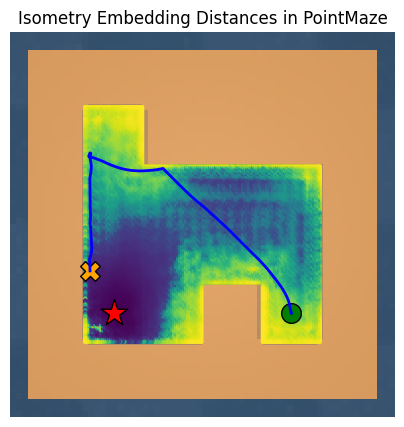

In [188]:
# Apply probability integral transform to distances
distances_pobs = pit_empirical(distances_1_l2)

plt.figure(figsize=(5, 5))
plt.imshow(goal_frame, extent=(-3.25, 3.25, -3.25, 3.25))
sc = plt.scatter(
    samples_rotated[:, 0], samples_rotated[:, 1],
    c=distances_pobs, cmap='viridis', s=5
)
# plt.colorbar(sc, label='Cosine Distance to Goal Frame')

# Initial position marker
initial_pos_rotated = rotate90_and_hflip(initial_position.reshape(1, -1))
plt.scatter(
    initial_pos_rotated[0, 0], initial_pos_rotated[0, 1],
    color='green', s=200, edgecolor='black', label='Initial Position'
)
# Goal position marker
goal_pos_rotated = rotate90_and_hflip(goal_position.reshape(1, -1))
plt.scatter(
    goal_pos_rotated[0, 0], goal_pos_rotated[0, 1],
    color='red', s=400, edgecolor='black', label='Goal Position', marker='*'
)

# Planned path
positions_rotated = rotate90_and_hflip(positions)
plt.plot(
    positions_rotated[:, 0], positions_rotated[:, 1],
    color='blue', linewidth=2, label='Planned Path'
)
plt.scatter(
    positions_rotated[-1, 0], positions_rotated[-1, 1],
    color='orange', s=200, edgecolor='black', label='Final Position', marker='X'
)

plt.title("Isometry Embedding Distances in PointMaze")
plt.xlim(-3.25, 3.25)
plt.ylim(-3.25, 3.25)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.show()

In [189]:
# Save video with imageio
video_path = "planned_path.mp4"
imageio.mimwrite(video_path, frames, fps=20)
# Display video in notebook
Video(video_path, embed=True, width=400)